In [1]:
import pandas as pd
import numpy as np
from boruta import BorutaPy 

In [2]:
from pycaret.classification import *

Let us first check for missing values:

In [3]:
#Read data
raw_data = pd.read_csv('employee_churn_data.csv')
#Check for missing values
raw_data.isna().sum()

department       0
promoted         0
review           0
projects         0
salary           0
tenure           0
satisfaction     0
bonus            0
avg_hrs_month    0
left             0
dtype: int64

In [4]:
raw_data.shape

(9540, 10)

As we can see, there are no missing values in the dataset.
Let's split the data into training and test set, and then perform analyses and modeling on the training set.

In [5]:
from sklearn.model_selection import train_test_split as tts
train, test = tts(raw_data,test_size=0.2,random_state=32)
train = pd.DataFrame(train,columns=raw_data.columns)
train.reset_index(level=None,inplace=True,drop=True)
test = pd.DataFrame(test,columns=raw_data.columns)
test.reset_index(level=None,inplace=True,drop=True)

In [83]:
test.to_csv('employee_churn_test.csv')

Let us see the frequencies of employees who left vs those who stayed.

<BarContainer object of 2 artists>

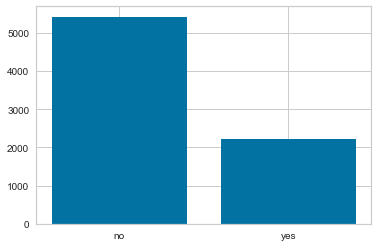

In [6]:
#Graph the frequencies of those who churned vs those who  did not
import matplotlib.pyplot as plt
plt.bar(train['left'].value_counts().index,train['left'].value_counts())

We could see that there are substantially more empoyees who stayed compared to those who left. This could be considered a class imbalance. We will come back to this during the modeling process. For now let us check the number of churned and retained employees for each of the categorical variables, namely promotion, department, salary grade, and bonus.

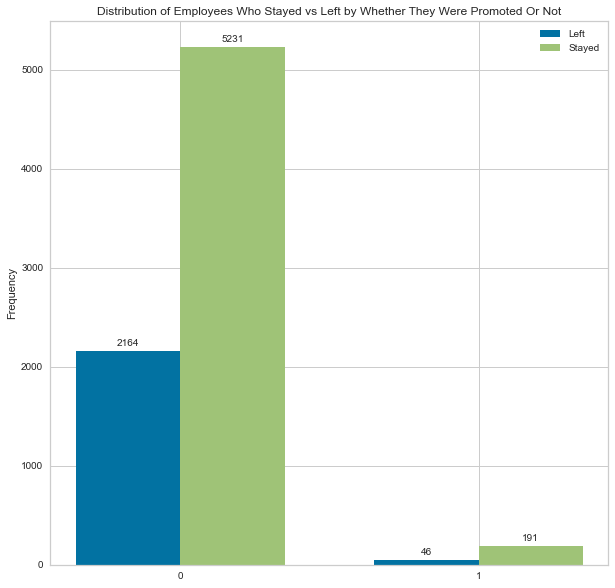

In [7]:
#Define graphing function
def bar_graphs(labels, arr1, arr2, title):
    
    #Place figure and make bar graphs
    labels = labels
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10,10))
    rects1 = ax.bar(x - width/2, arr1, width, label='Left')
    rects2 = ax.bar(x + width/2, arr2, width, label='Stayed')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.set_xticks(x,labels)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)   
    
#Graph frequencies of churned vs retained employees by promotion status
bar_graphs(train['promoted'].value_counts().index,
           train.loc[(train['left']=='yes'),'promoted'].value_counts(),
           train.loc[(train['left']=='no'),'promoted'].value_counts(),
           'Distribution of Employees Who Stayed vs Left by Whether They Were Promoted Or Not')

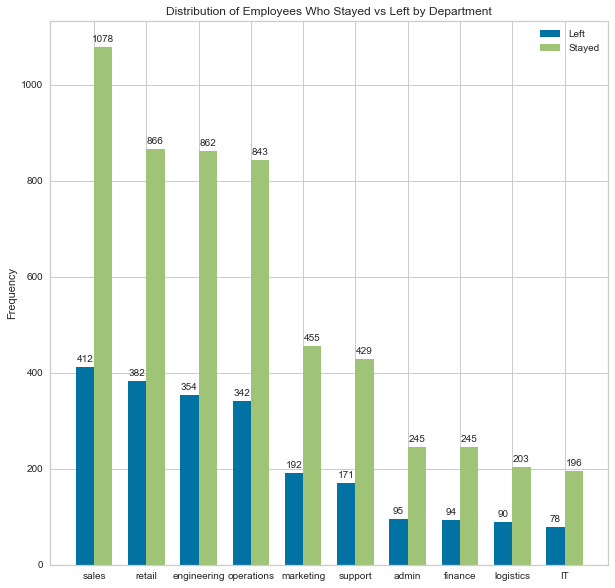

In [8]:
#Graph frequencies of churned vs retained employees by department
bar_graphs(train['department'].value_counts().index,
           train.loc[(train['left']=='yes'),'department'].value_counts(),
           train.loc[(train['left']=='no'),'department'].value_counts(),
          'Distribution of Employees Who Stayed vs Left by Department')

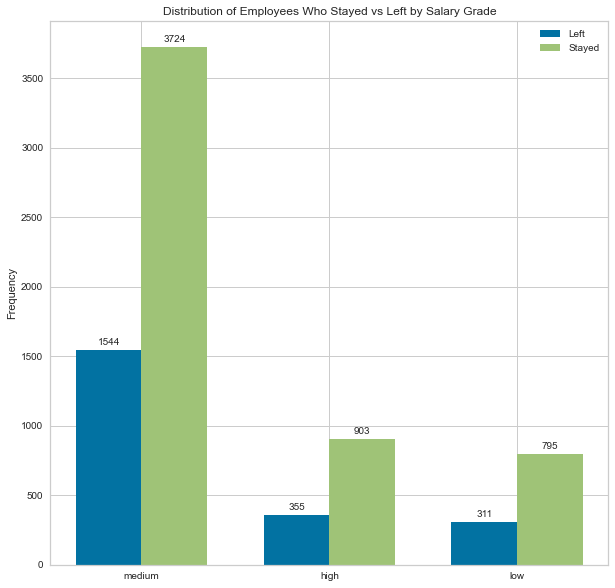

In [9]:
#Graph frequencies of churned vs retained employees by salary grade
bar_graphs(train['salary'].value_counts().index,
           train.loc[(train['left']=='yes'),'salary'].value_counts(),
           train.loc[(train['left']=='no'),'salary'].value_counts(),
          'Distribution of Employees Who Stayed vs Left by Salary Grade')

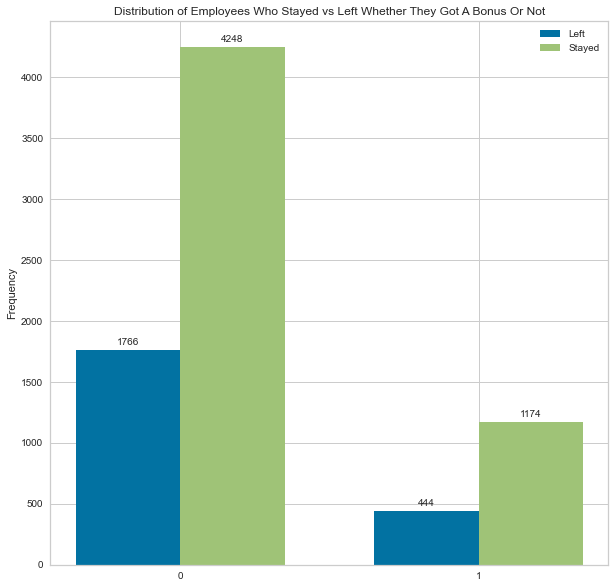

In [10]:
#Graph frequencies of churned vs retained employees by whether they got a bonus or not
bar_graphs(train['bonus'].value_counts().index,
           train.loc[(train['left']=='yes'),'bonus'].value_counts(),
           train.loc[(train['left']=='no'),'bonus'].value_counts(),
          'Distribution of Employees Who Stayed vs Left Whether They Got A Bonus Or Not')

The ratio of employees who left vs who were retained doesn't seem to significantly differ between the categories of each variable. This may suggest that these variables won't be very influential in identifying employees that would leave the company.

Let us now take a look at the continuous variables.

In [11]:
train[['review','projects','tenure','satisfaction','avg_hrs_month']].describe()

,review,projects,tenure,satisfaction,avg_hrs_month
count,7632.000000,7632.000000,7632.000000,7632.000000,7632.000000
mean,0.651366,3.276074,6.549528,0.505192,184.631365
std,0.085866,0.577537,1.421205,0.159187,4.163008
min,0.310000,2.000000,2.000000,0.000000,171.374060
25%,0.591343,3.000000,5.000000,0.386019,181.458141
50%,0.646676,3.000000,7.000000,0.502171,184.567823
75%,0.708208,4.000000,8.000000,0.624874,187.698120
max,1.000000,5.000000,12.000000,1.000000,200.861656


Let us produce boxplots to determine the spread of continuous variables' values grouped by churn category.

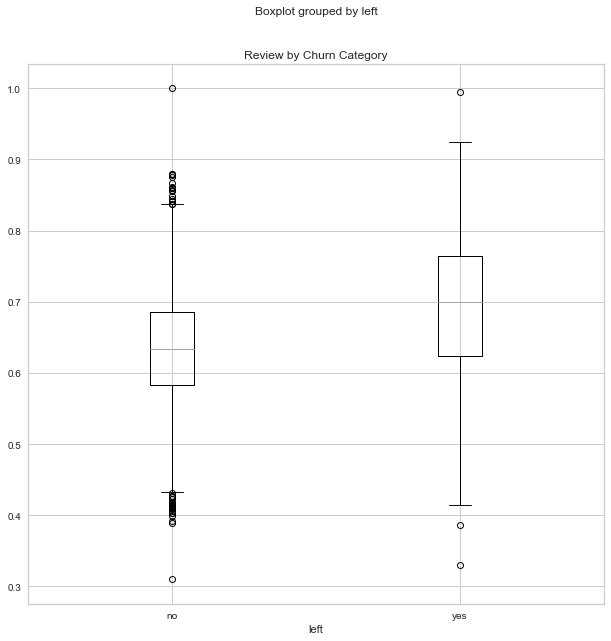

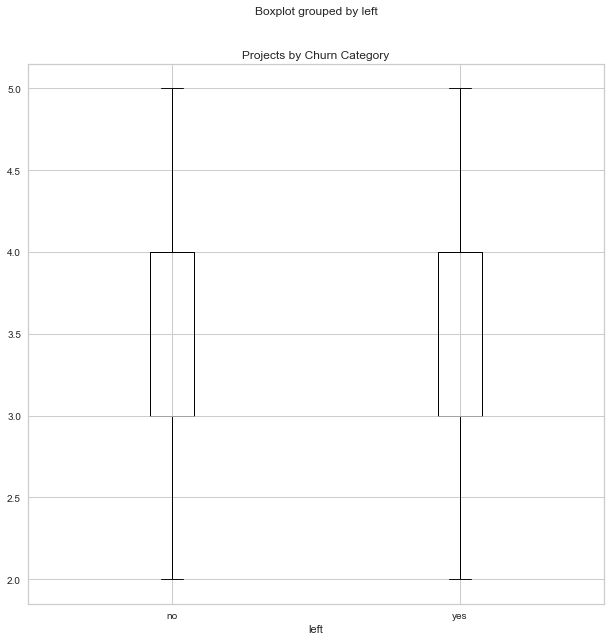

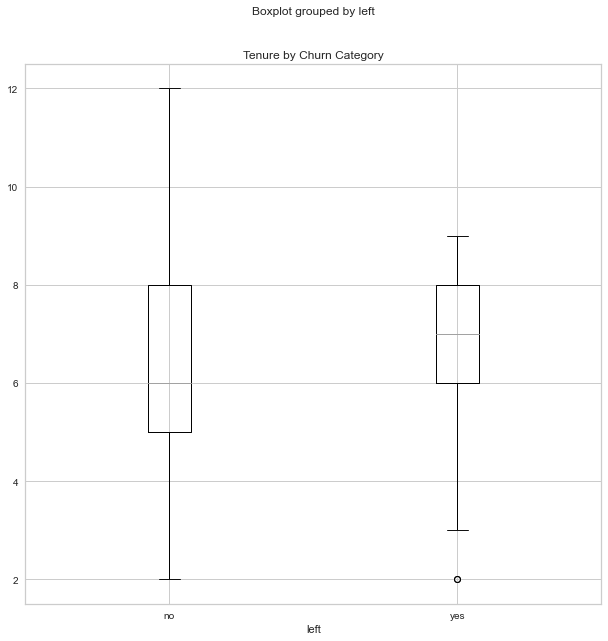

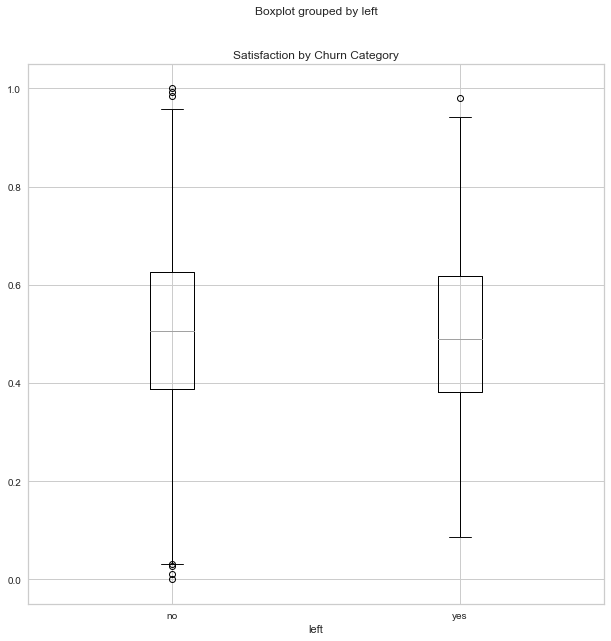

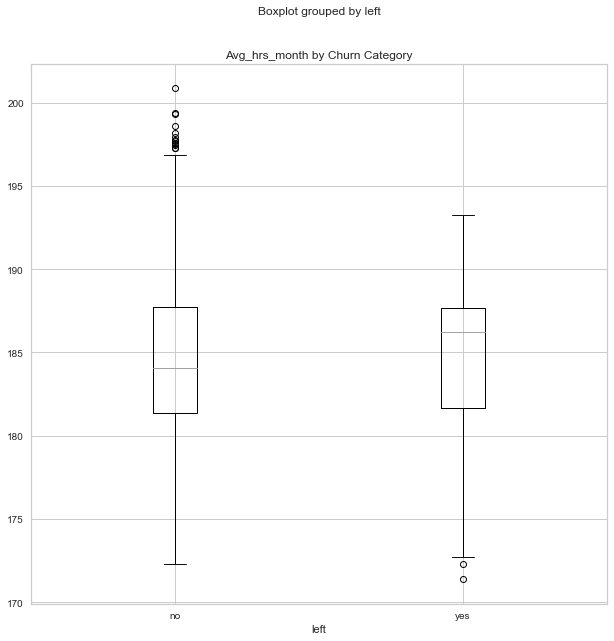

In [12]:
#Plot continuous variables' distribution by churn category
for col in ['review','projects','tenure','satisfaction','avg_hrs_month']:
    train.boxplot(column=col, by='left', figsize=(10,10))
    plt.title(col.capitalize() + ' ' + 'by Churn Category')
plt.show()

There seems to be higher median values for review, tenure, and average hours worked among employees who left. These variables may have the most influence in predicting which emplpoyees would leave. Employee satisfaction seems to be more vague, because while the medians are similar, the distribution of satisfaction scores among retained employees vary more wildly.

Let us preprocess the data and perform variable selection through the Boruta method.

In [13]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
boruta = BorutaPy(rf,n_estimators='auto',verbose=2, random_state=1)

In [14]:
#Preprocess data for boruta usage
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

train_copy = train.copy()

#Change left categories into 1 and 0, and transform salary into ordinal values
recode = {'yes':1,'no':0}
recode2 = {'low':1,'medium':2,'high':3}
train_copy['left'] = train_copy['left'].map(recode)
train_copy['salary'] = train_copy['salary'].map(recode2)

#Scale coontinuous variables and one-hot encode department
ct = ColumnTransformer([('deptonehot',OneHotEncoder(dtype=int),['department']),
                       ('scaler',StandardScaler(),['review','projects','tenure','satisfaction','avg_hrs_month'])],
                       remainder='passthrough')
preprocessed_train = ct.fit_transform(train_copy)

#Transform to dataframe
features = []
for feature in train.groupby('department').size().index:
    features.append(feature)
for feature in ('review','projects','tenure','satisfaction','avg_hrs_month','promoted','salary','bonus','left'):
    features.append(feature)

Let us save the column transformer object so that it could be deployed onto new data.

In [17]:
from pickle import dump
dump(ct, open('column_transformer.pkl', 'wb'))

In [15]:
target = train_copy['left'].values
boruta.fit(preprocessed_train[:,:18],target)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	4
Tentative: 	0
Rejected: 	14


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	4
Tentative: 	0
Rejected: 	14


BorutaPy(estimator=RandomForestClassifier(n_estimators=60,
                                          random_state=RandomState(MT19937) at 0x27B72733D40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x27B72733D40, verbose=2)

In [16]:
boruta.support_

array([False, False, False, False, False, False, False, False, False,
       False,  True, False,  True,  True,  True, False, False, False])

In [17]:
#print(train_copy.shape)
#print(preprocessed_train.shape)
print(features)

['IT', 'admin', 'engineering', 'finance', 'logistics', 'marketing', 'operations', 'retail', 'sales', 'support', 'review', 'projects', 'tenure', 'satisfaction', 'avg_hrs_month', 'promoted', 'salary', 'bonus', 'left']


Selected features are review, tenure, satisfaction, and avg_hours_month.

Based on the box plots of these features shown earlier, some univariate outliers are present. Let us look for multivariate outliers using the (squared) Mahalanobis Distance and using a standard cut-off to find outliers and remove them. We will use the MCD estimate of robust covariance and robust mean as introduced by P.J.Rousseuw (1999), because the empirical estimates of covariance and mean are sensitive to outliers.

The squared Mahalanobis distance follows a chi-square distribution with the degrees of freedom being equal to the number of features used. The cut-off used will be the quantile corresponding to the 95th percentile.

In [18]:
preprocessed_train = pd.DataFrame(preprocessed_train,columns=features)
preprocessed_train.head()

,IT,admin,engineering,finance,logistics,marketing,operations,retail,sales,support,review,projects,tenure,satisfaction,avg_hrs_month,promoted,salary,bonus,left
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.367970,-0.478052,1.020660,-0.564598,0.914374,0.0,2.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.525186,-0.478052,-1.090363,0.655255,-1.246544,0.0,3.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.075971,-0.478052,0.316985,2.002659,0.383439,0.0,2.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.843132,-0.478052,2.428008,0.846976,2.348765,0.0,2.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.165290,-2.209656,0.316985,-0.591033,0.051378,0.0,2.0,1.0,1.0


In [19]:
#Get the features chosen by the boruta method
train_filtered = preprocessed_train[['review','tenure','satisfaction','avg_hrs_month','left']]

'''''''''
#Mahalanobis Distance
cov = np.cov(train_filtered.iloc[:,:4],rowvar=False)   #Covariance matrix
inv_covmat = np.linalg.inv(cov)                        #Inverse of covariance matrix
mean = np.mean(train_filtered.iloc[:,:4])
distances = []
for i, val in enumerate(train_filtered.iloc[:,:4].values):
    diff = val - mean  
    vector = diff.T
    left_term = np.dot(vector, inv_covmat) 
    distance_squared = np.dot(left_term, diff)
    distances.append(distance_squared)
distances = np.array(distances)
'''''''''

#Mahalanobis Distance using MCD
from sklearn.covariance import MinCovDet as MCD
cov = MCD(random_state=1).fit(X=train_filtered.iloc[:,:4])
distance = cov.mahalanobis(train_filtered.iloc[:,:4])

#Apply cutoff to find outliers
from scipy.stats import chi2
cutoff = chi2.ppf(0.95, train_filtered.iloc[:,:4].shape[1])
outlier_indexes = np.where(distance > cutoff)


In [20]:
print(cutoff)
print(max(distance))
print(outlier_indexes[0])
print(outlier_indexes[0].shape)

9.487729036781154
98.35935035793635
[   3    8   13 ... 7596 7598 7619]
(1007,)


1007 outliers have been detected. Let us remove these outliers and train a model.

In [21]:
outliers = outlier_indexes[0]
train_no_outliers = train_filtered.drop(outliers,axis=0)

In [22]:
print(train_filtered.shape)
print(train_no_outliers.shape)

(7632, 5)
(6625, 5)


In [23]:
s = setup(train_no_outliers,'left')

,Description,Value
0,session_id,3974
1,Target,left
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(6625, 5)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [24]:
best = compare_models(sort='auc')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8527,0.9129,0.6957,0.7848,0.7373,0.6355,0.6379,0.0560
gbc,Gradient Boosting Classifier,0.8557,0.9069,0.6703,0.8112,0.7335,0.6359,0.6418,0.1770
rf,Random Forest Classifier,0.8473,0.9039,0.6812,0.7777,0.7259,0.6207,0.6237,0.2610
et,Extra Trees Classifier,0.8430,0.9033,0.6856,0.7629,0.7215,0.6127,0.6149,0.2140
knn,K Neighbors Classifier,0.8434,0.8819,0.7074,0.7515,0.7285,0.6186,0.6194,0.0230
qda,Quadratic Discriminant Analysis,0.7878,0.8264,0.4531,0.7317,0.5591,0.4293,0.4511,0.0130
ada,Ada Boost Classifier,0.7537,0.8229,0.3987,0.6372,0.4894,0.3386,0.3552,0.0920
dt,Decision Tree Classifier,0.7962,0.7557,0.6558,0.6574,0.6561,0.5114,0.5118,0.0130
lr,Logistic Regression,0.7156,0.7078,0.2085,0.5551,0.3023,0.1684,0.2002,1.5390
lda,Linear Discriminant Analysis,0.7162,0.7078,0.2179,0.5559,0.3123,0.1751,0.2056,0.0110


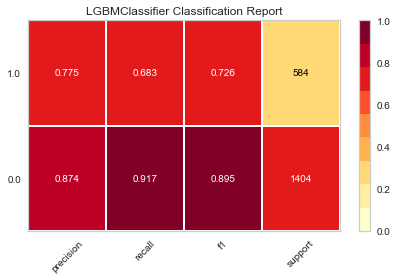

In [25]:
plot_model(best,'class_report')

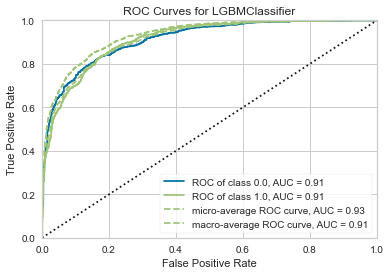

In [26]:
plot_model(best,'auc')

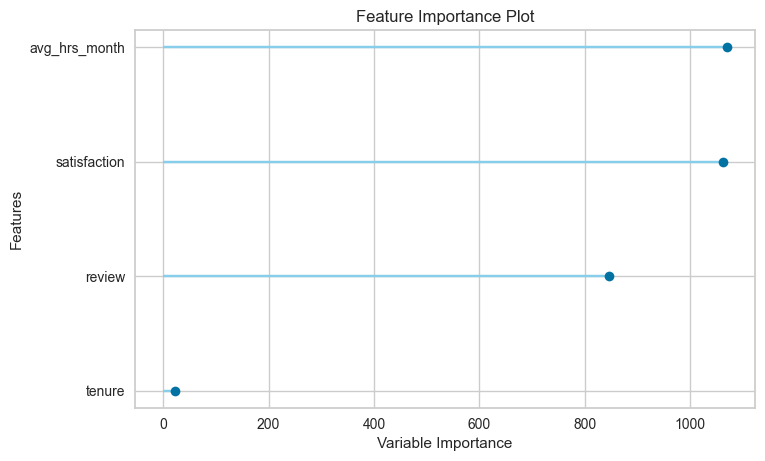

In [27]:
plot_model(best,'feature')

The resulting best model is a Light Gradient Boosting Machine with an AUC of 0.9129 and an accuracy of 85.27%. A high AUC indicates high predictive power give all possible threshold probability values. 

PyCaret gives the option to fine tune your selected model. Let us do so and compare with the original.

In [28]:
model = best
tuned_model = tune_model(model,optimize='auc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8254,0.8982,0.6377,0.7395,0.6848,0.5650,0.5680
1,0.8599,0.9204,0.7319,0.7829,0.7566,0.6584,0.6591
2,0.8707,0.9257,0.7029,0.8362,0.7638,0.6757,0.6805
3,0.8534,0.9138,0.7101,0.7778,0.7424,0.6403,0.6416
4,0.8599,0.9235,0.7174,0.7920,0.7529,0.6554,0.6570
5,0.8534,0.9105,0.6449,0.8241,0.7236,0.6259,0.6346
6,0.8470,0.9023,0.6594,0.7913,0.7194,0.6154,0.6202
7,0.8661,0.9000,0.7226,0.8049,0.7615,0.6688,0.6707
8,0.8704,0.9118,0.7226,0.8182,0.7674,0.6781,0.6806


In [29]:
print(model)
print(tuned_model)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=3974, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
LGBMClassifier(bagging_fraction=1.0, bagging_freq=5, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
               importance_type='split', learning_rate=0.15, max_depth=-1,
               min_child_samples=41, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=200, n_jobs=-1, num_leaves=200, objective=None,
               random_state=3974, reg_alpha=1, reg_lambda=0.0001, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


Original model is better. 

We could see that while the model has a high AUC, its recall is 0.683, which means that only 68.3% of employees who left the company were correctly identified by the model. This may be due to the observed class imbalance. Let us retrain the model by adding different class weights in the loss function that the model minimizes. We can do this by setting the is_unbalance parameter to True.

In [30]:
#create_model('lightgbm',is_unbalance=True)
create_model('lightgbm',is_unbalance=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8233,0.9012,0.7681,0.6795,0.7211,0.5925,0.5948
1,0.8513,0.9220,0.8261,0.7170,0.7677,0.6591,0.6627
2,0.8599,0.9275,0.7971,0.7483,0.7719,0.6710,0.6717
3,0.8082,0.9116,0.7971,0.6433,0.7120,0.5706,0.5780
4,0.8297,0.9246,0.7826,0.6879,0.7322,0.6082,0.6109
5,0.8405,0.9149,0.8116,0.7000,0.7517,0.6352,0.6389
6,0.8319,0.9056,0.7899,0.6899,0.7365,0.6139,0.6169
7,0.8229,0.9001,0.7810,0.6730,0.7230,0.5939,0.5974
8,0.8380,0.9034,0.7883,0.7013,0.7423,0.6247,0.6270


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', is_unbalance=True, learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=3974, reg_alpha=0.0, reg_lambda=0.0,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

It seems that adjusting the class weights did not improve the model. The next thing we can do is fix the class imbalance in the data itself. We can do random oversampling of the minority class (in this case, employees who left) and perform modeling on the new data.

In [31]:
from imblearn.over_sampling import RandomOverSampler
sampler = RandomOverSampler(sampling_strategy=0.5)
s2 = setup(train_no_outliers,'left',fix_imbalance=True,fix_imbalance_method=sampler)

,Description,Value
0,session_id,4718
1,Target,left
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(6625, 5)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [32]:
best2 = compare_models(sort='auc')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8503,0.9174,0.7100,0.7719,0.7390,0.6345,0.6360,0.0460
rf,Random Forest Classifier,0.8484,0.9112,0.6977,0.7748,0.7333,0.6279,0.6303,0.2880
et,Extra Trees Classifier,0.8454,0.9087,0.6861,0.7726,0.7261,0.6190,0.6217,0.2210
gbc,Gradient Boosting Classifier,0.8458,0.9080,0.6783,0.7785,0.7242,0.6180,0.6214,0.1880
knn,K Neighbors Classifier,0.8352,0.8804,0.7374,0.7193,0.7277,0.6097,0.6102,0.0320
ada,Ada Boost Classifier,0.7757,0.8216,0.5340,0.6547,0.5873,0.4356,0.4405,0.1150
qda,Quadratic Discriminant Analysis,0.7848,0.8201,0.4993,0.6951,0.5809,0.4413,0.4524,0.0120
dt,Decision Tree Classifier,0.8055,0.7674,0.6725,0.6758,0.6733,0.5350,0.5356,0.0160
lr,Logistic Regression,0.7136,0.7059,0.2857,0.5434,0.3738,0.2104,0.2293,0.0180
lda,Linear Discriminant Analysis,0.7112,0.7056,0.2915,0.5343,0.3765,0.2089,0.2257,0.0130


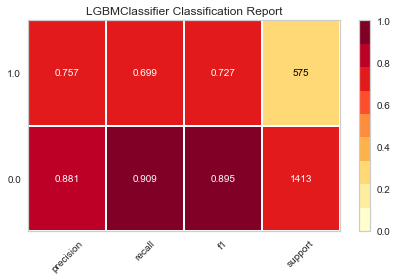

In [33]:
plot_model(best2,'class_report')

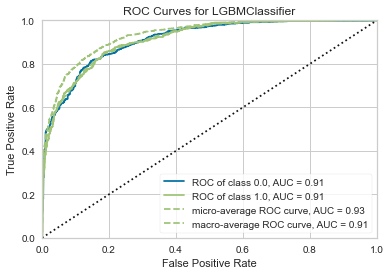

In [34]:
plot_model(best2,'auc')

This model has a higher AUC than our initial model, and it does have better recall at 0.699. Let us try one last round of modeling where we use a different oversampling method called SMOTE, which is the default of the setup() function when fix_imbalance is set to True.

In [35]:
s3 = setup(train_no_outliers,'left',fix_imbalance=True)

,Description,Value
0,session_id,1139
1,Target,left
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(6625, 5)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [36]:
best3 = compare_models(sort='auc')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8344,0.9175,0.8053,0.6837,0.7391,0.6190,0.6239,0.0550
rf,Random Forest Classifier,0.8380,0.9107,0.7720,0.7039,0.7352,0.6191,0.6216,0.3620
gbc,Gradient Boosting Classifier,0.8191,0.9107,0.8238,0.6497,0.7262,0.5940,0.6036,0.2470
et,Extra Trees Classifier,0.8370,0.9078,0.7646,0.7039,0.7320,0.6153,0.6173,0.2510
knn,K Neighbors Classifier,0.8091,0.8778,0.8142,0.6350,0.7129,0.5733,0.5840,0.0350
ada,Ada Boost Classifier,0.7671,0.8246,0.7861,0.5744,0.6630,0.4918,0.5067,0.1180
qda,Quadratic Discriminant Analysis,0.7259,0.8199,0.7498,0.5207,0.6144,0.4124,0.4291,0.0140
dt,Decision Tree Classifier,0.8022,0.7801,0.7269,0.6423,0.6817,0.5391,0.5415,0.0200
lr,Logistic Regression,0.6618,0.7085,0.6817,0.4476,0.5401,0.2906,0.3070,0.0230
lda,Linear Discriminant Analysis,0.6623,0.7085,0.6847,0.4482,0.5414,0.2923,0.3091,0.0150


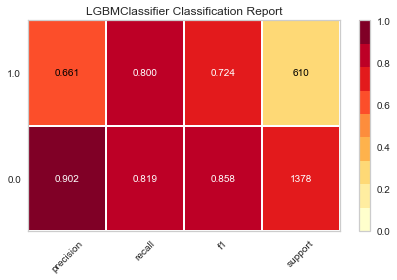

In [37]:
plot_model(best3,'class_report')

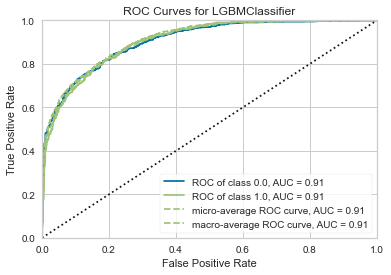

In [39]:
plot_model(best3,'auc')

This model has an even better recall at 0.80, while also having the highest AUC yet. Let us see if we can tune it to perform better.

In [40]:
tune_model(best3,optimize='auc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8103,0.8976,0.8148,0.6358,0.7143,0.5756,0.5855
1,0.8254,0.9102,0.7778,0.6731,0.7216,0.5955,0.5988
2,0.8254,0.9148,0.8148,0.6627,0.7309,0.6037,0.6108
3,0.8534,0.9260,0.8222,0.7161,0.7655,0.6597,0.6630
4,0.8125,0.9110,0.7926,0.6446,0.7110,0.5744,0.5811
5,0.8319,0.9090,0.8444,0.6667,0.7451,0.6223,0.6319
6,0.8599,0.9316,0.8235,0.7320,0.7751,0.6739,0.6763
7,0.8661,0.9406,0.9111,0.7110,0.7987,0.7006,0.7127
8,0.8056,0.9005,0.7852,0.6347,0.7020,0.5601,0.5671


LGBMClassifier(bagging_fraction=0.9, bagging_freq=2, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.8,
               importance_type='split', learning_rate=0.4, max_depth=-1,
               min_child_samples=41, min_child_weight=0.001, min_split_gain=0.4,
               n_estimators=180, n_jobs=-1, num_leaves=80, objective=None,
               random_state=1139, reg_alpha=3, reg_lambda=0.001, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

It seems like no further tuning is necessary. Let us look at the feature importance and SHAP values of this final model for interpretation.

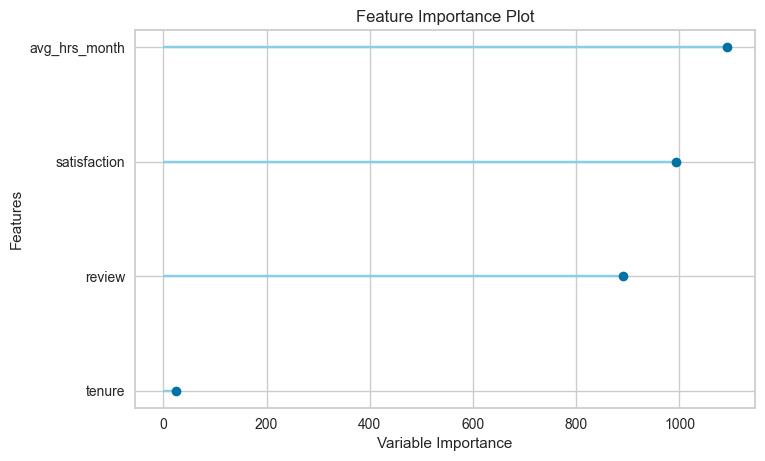

In [41]:
plot_model(best3, 'feature')

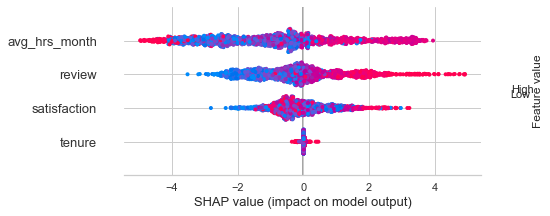

In [42]:
interpret_model(best3)

Red dots represent higher values of the feature while blue dots represent lower values of the feature.

The interpretation is that in general, the more hours an employee works on average, the higher the chance of leaving. The lower the performance review rating, the less likely an employee will leave. For employee satisfaction, there is a small number of highly satisfied employees who ended up leaving but generally there are more red points on the left side of the graph, which mean that more satisfied employees are less likely to leave. Tenure relatively seems to have little impact on the outcome of predictions.

The findings on employee performance review ratings and satisfaction are interesting, where most employees with lower ratings tend to stay instead of leaving. Findings like these warrant further review, perhaps relating to company culture and personal motivations of each employee. Same could be said about the findings with employee satisfaction.

Let us save this model.

In [43]:
save_model(best3,'employee_churn_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='left',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strateg...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, importance_type='split',
                                 learning_rate=0.1, max_depth=-1,
                                 min_child_samples=20,